Import Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
import os



Download NLTK Resources

In [23]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [24]:

file_path = "data/amazon_reviews_data.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")

df[['reviews.text', 'reviews.rating']].dropna()
df[df['reviews.text'].str.strip() != '']
df[df['reviews.title'].str.strip() != '']
df['full_review'] = df['reviews.title'].fillna('') + ' - ' + df['reviews.text'].fillna('')
df.rename(columns={'reviews.rating': 'rating','reviews.doRecommend' : 'doRecommend'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)

# After first columns exploration here are the columns we will drop as they do not provide useful information for future activities
columntodrop = ["id","dateAdded","dateUpdated","keys","manufacturer","manufacturerNumber","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.text","reviews.title","reviews.username","reviews.didPurchase"]
df.drop(columns=columntodrop, inplace=True, errors='ignore')
print(f"After removing columns: {df.shape}")

##Remove DUplicates 
print(f"Number of duplicate reviews: {df.duplicated(subset=['full_review']).sum()}")
df = df.drop_duplicates(subset=['full_review'])
print(f"Shape after dropping duplicates: {df.shape}")
df.columns

Original shape: (33332, 25)
After removing missing: (33332, 26)
After removing columns: (33332, 10)
Number of duplicate reviews: 13269
Shape after dropping duplicates: (20063, 10)


C:\Users\jeand\AppData\Local\Temp\ipykernel_19140\1789562783.py:2: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Index(['name', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'sourceURLs', 'full_review'],
      dtype='object')

Visualize Ratings Distribution

C:\Users\jeand\AppData\Local\Temp\ipykernel_19140\2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


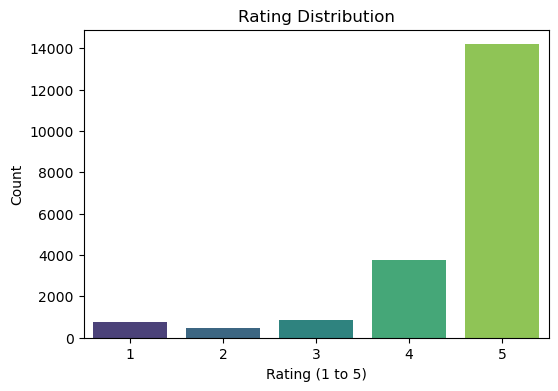

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

C:\Users\jeand\AppData\Local\Temp\ipykernel_19140\759677541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


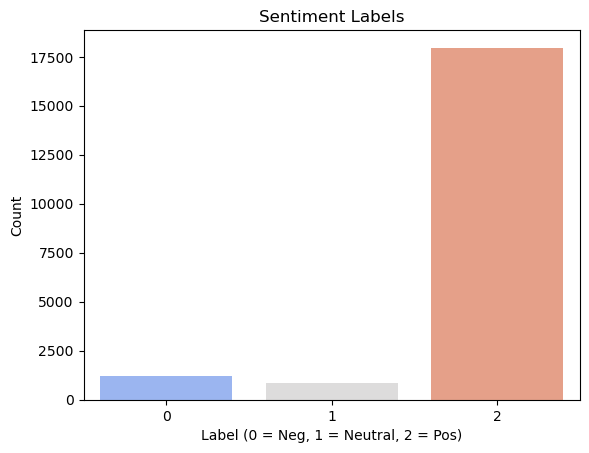

In [26]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()

Clean Text (Simple + Stopwords + Stemming)

In [27]:
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['full_review'].apply(simple_clean_text)
df[['full_review', 'clean_text']].sample(3)


,full_review,clean_text
17934,Best kindle ever! - I purchased this specifica...,best kindl ever purchas specif take cruis exce...
1085,Excellent product - Excellent product. Turns o...,excel product excel product turn support devic...
25248,Great tablet - Love reading and able to carry ...,great tablet love read abl carri book everwher...


Dropping full_reviews column

In [28]:
df.drop(columns='full_review', inplace=True, errors='ignore')
df.columns

Index(['name', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'sourceURLs', 'label',
       'clean_text'],
      dtype='object')

Top Common Words per Sentiment Class

In [29]:
from collections import Counter
import pandas as pd

def get_top_n_words(text_series, n=15):
    # Ensure we are dealing with strings
    all_words = ' '.join(text_series.dropna().astype(str)).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

# Loop through each sentiment label and show top words
for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'], n=15)
    print(top_words)



🔹 Top words for Negative reviews:
       word  count
0   batteri   1496
1      last    555
2       use    499
3    amazon    381
4       one    377
5      work    336
6      dont    323
7       buy    285
8      star    267
9      long    229
10     good    219
11    brand    211
12     time    209
13  purchas    196
14      get    193

🔹 Top words for Neutral reviews:
       word  count
0   batteri    470
1      good    324
2    tablet    258
3      last    255
4       use    234
5      long    201
6     price    200
7     great    189
8     three    187
9      work    185
10     star    179
11     dont    161
12   amazon    157
13     like    152
14      get    149

🔹 Top words for Positive reviews:
       word  count
0     great  11624
1   batteri   8156
2    tablet   5823
3      good   5747
4      love   5084
5     price   5021
6       use   4701
7      work   3664
8      star   3172
9    amazon   2895
10     five   2597
11  product   2443
12      kid   2360
13    kindl   2335
14 

Word Cloud per Sentiment Class

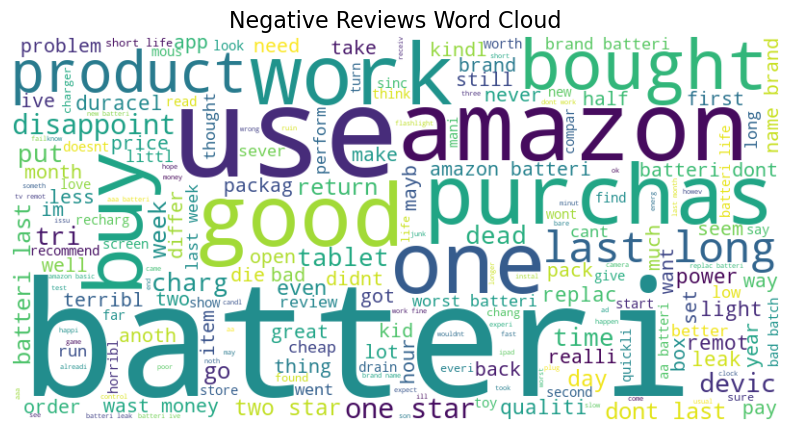

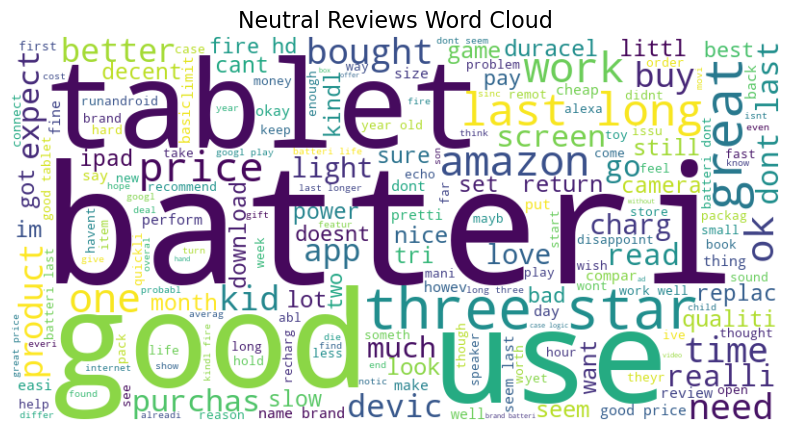

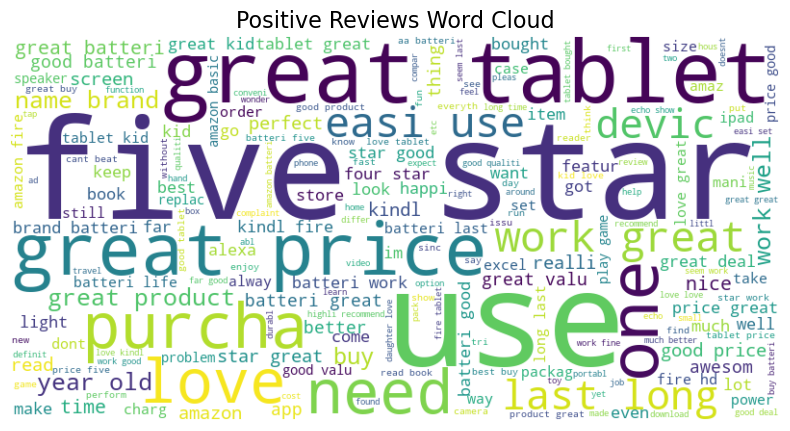

In [30]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [31]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")

✅ Saved: data/cleaned_amazon_reviews_final.csv
